Import useful programs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ompy as om
import logging

import scipy as sp
#%matplotlib widget
from ipywidgets import widgets #interact, interactive, fixed, interact_manual

In [2]:
om.__full_version__

'0.9.1.dev0+ed04b86'

In [3]:
# For reproducability we seed the random generator.
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [4]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

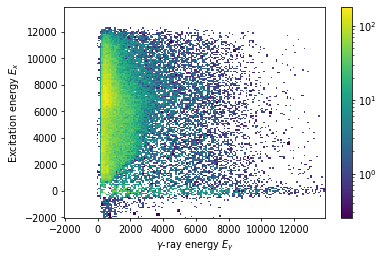

In [5]:
# Import raw matrix into instance of om.Matrix()
raw = om.Matrix(path="/home/tellefs/Documents/master/master_calibration/usersort_U233/alfna.m")

#Rebin raw matrix
raw.rebin(0,factor=12)
raw.rebin(1,factor=12)
raw.plot();

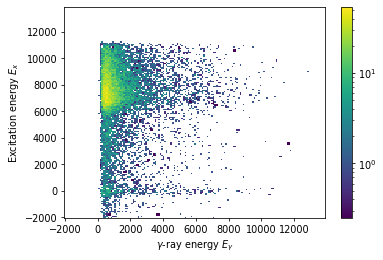

In [6]:
#import fission matrix for calibration
raw_fiss = om.Matrix(path="/home/tellefs/Documents/master/master_calibration/usersort_U233/alfna_fiss.m")

#Rebin raw matrix
raw_fiss.rebin(0,factor=12)
raw_fiss.rebin(1,factor=12)
raw_fiss.plot();

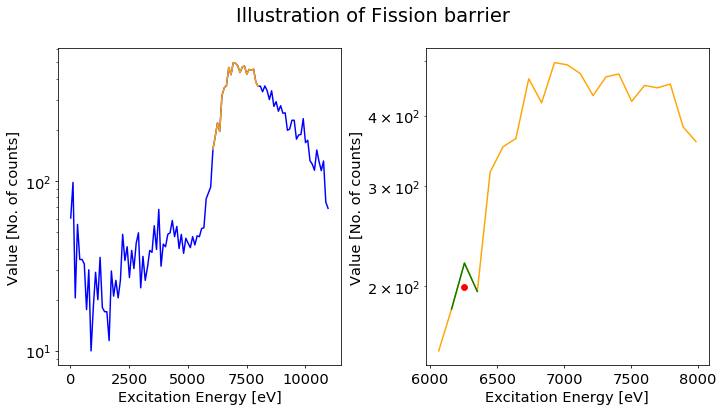

In [7]:
# Calibrate spectra to the theoretical fission barrier
# Plot projections
#raw.plot_projection('Ex', scale='log', kind="step");
#raw.plot_projection('Ex', kind="step");

#Find inner and outer fission barrier in raw matrix
fiss = raw_fiss.copy()
Ex_array = fiss.projection(1)

#cut Ex_array
y = []
x = []
for i in range(len(Ex_array[1])):
    if Ex_array[1][i]>=0. and Ex_array[1][i]<=11000.:
        y.append(Ex_array[0][i])
        x.append(Ex_array[1][i])

#Cut Ex_array to see closer
y2 = []
x2 = []
for i in range(len(Ex_array[1])):
    if Ex_array[1][i]>=6000. and Ex_array[1][i]<=8000.:
        y2.append(Ex_array[0][i])
        x2.append(Ex_array[1][i])
              
y3 = []
x3 = []
for i in range(len(Ex_array[1])):
    if Ex_array[1][i]>=6100. and Ex_array[1][i]<=6400.:
        y3.append(Ex_array[0][i])
        x3.append(Ex_array[1][i])

fiss_barr = np.mean(x3, dtype=np.float64)*1e-3
fiss_barr_y = np.mean(y3, dtype=np.float64)

fig, ax = plt.subplots(1,2, figsize=(12, 6))
fig.subplots_adjust(wspace=0.3)
plt.tick_params(axis='both', which='minor', labelsize=15)

ax[0].plot(x, y, color='blue')
ax[0].plot(x2, y2, color='orange')
ax[0].tick_params(axis='both', labelsize=15)
ax[0].set_xlabel('Excitation Energy [eV]', fontsize=15)
ax[0].set_ylabel('Value [No. of counts]', fontsize=15)
ax[0].set_yscale('log')

ax[1].plot(x2, y2, color='orange')
ax[1].plot(x3, y3, color='green')
ax[1].plot(fiss_barr*1e3, fiss_barr_y, 'ro')
ax[1].tick_params(axis='both', labelsize=15)
ax[1].set_yscale('log')
ax[1].set_xlabel('Excitation Energy [eV]', fontsize=15)
ax[1].set_ylabel('Value [No. of counts]', fontsize=15)
fig.suptitle('Illustration of Fission barrier', fontsize=20)
fig.savefig('plots/fission_barrier_plot', dpi=1000)
fig.show()

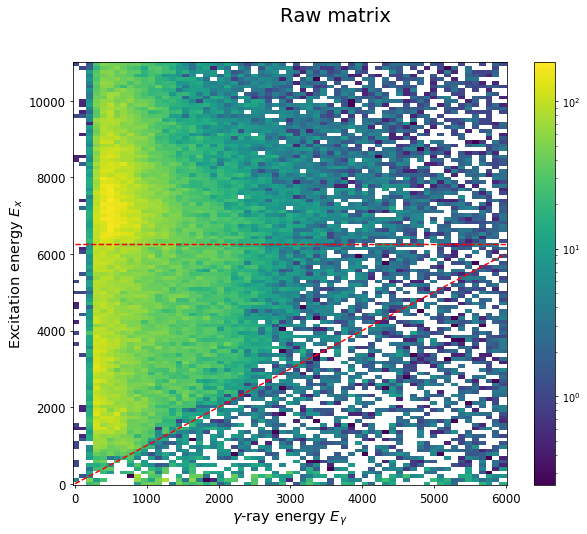

In [8]:
#plot raw matrix
raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 11000)
raw_plot_big.cut('Eg', 0, 6000)


fig, ax = plt.subplots(figsize=(10, 8))

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$',fontsize=15)
ax.set_ylabel('Excitation energy $E_x',fontsize=15)
fig.suptitle('Raw matrix', fontsize=20)
raw_plot_big.plot(ax=ax);
x = np.linspace(0, 6000, 100)
ax.plot(x, x, "r--", label="E_x = E_g");
ax.plot(x, np.ones(100)*fiss_barr*1e3, 'r--');
fig.savefig('plots/raw_uncalibrated', dpi=1000)


In [9]:
#New calibration to the theoretical fission barriers

#Fission barrier from RIPL3:

#Empirical HFB Fission barriers:
# Z   N   A  s     Bin     hwin   alphain deltain  Bout   hwout  alphaout deltaout Bout2  hwout2 alphaout2 deltaout2
#                 [MeV]   [MeV] [MeV^-1/2] [MeV]  [MeV]   [MeV] [MeV^-1/2] [MeV]  [MeV]   [MeV] [MeV^-1/2] [MeV]
# 92 142 234 U     5.38    0.66    0.00    0.00    6.15    0.45    0.00    0.00    2.27    0.28    0.00    0.00

#Empirical Barriers:
#  Z   A  s   Syma    Ea     hwa   Symb    Eb     hwb    Deltaf
#                   [MeV]   [MeV]        [MeV]   [MeV]    [MeV]
#  92 232 U     S     4.90    0.90   MA    5.40    0.60    0.848
#  92 233 U     S     4.35    0.80   MA    5.55    0.50    0.946
#  92 234 U     S     4.80    0.90   MA    5.50    0.60    0.8898


B_f_inner = 4.35 #MeV, outer fission barrier (See values above)
B_f_outer = 5.55 #MeV, inner fission barrier (See values above)

#B_f_inner_exp = 6.20571 #found with Root. Waiting on data to do this in this script
B_f_inner_exp = fiss_barr #MeV, found above

theo_Ex = [0., B_f_inner]
old_Ex = [0, B_f_inner_exp]

#Linefit to calibrate Ex
y_linefit = np.asarray(theo_Ex)
x_linefit = np.asarray(old_Ex)
z = np.polyfit(x_linefit, y_linefit, 1)
p = np.poly1d(z)
raw.Ex = raw.Ex*p[1] + p[0]

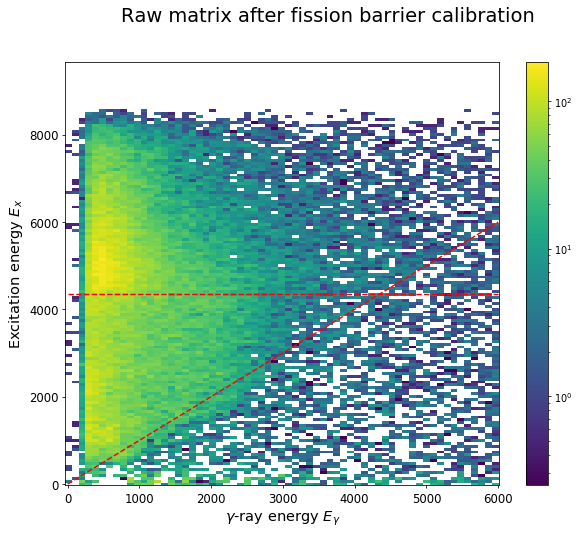

In [10]:
#plot raw matrix after calibration
raw_plot_big = raw.copy()
raw_plot_big.cut('Ex', 0, 11000)
raw_plot_big.cut('Eg', 0, 6000)


fig, ax = plt.subplots(figsize=(10, 8))

ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('$\gamma$-ray energy $E_\gamma$',fontsize=15)
ax.set_ylabel('Excitation energy $E_x',fontsize=15)
fig.suptitle('Raw matrix after fission barrier calibration', fontsize=20)
raw_plot_big.plot(ax=ax);
x = np.linspace(0, 6000, 100)
ax.plot(x, x, "r--", label="E_x = E_g");
ax.plot(x, np.ones(100)*B_f_inner*1e3, 'r--');
fig.savefig('plots/raw_calibrated', dpi=1000)


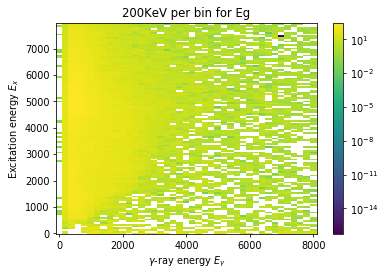

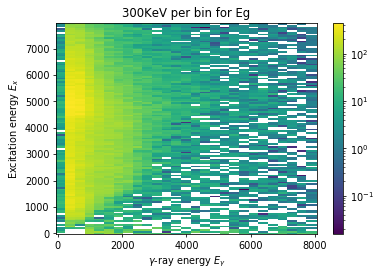

In [11]:
#Rebin raw matrix
#Going to try with 200KeV and 300KeV per bin

kev_per_bin = abs(raw.Eg[0]-raw.Eg[1])

raw_200 = raw.copy()
kev_wish = 200.
raw_200.rebin(0, factor=kev_wish/kev_per_bin) #rebinning the Eg energy axis
raw_200.cut('Ex', 0, 8000)
raw_200.cut('Eg', 0, 8000)
fig, ax = plt.subplots(1,1);
raw_200.plot(ax=ax, title='200KeV per bin for Eg');
plt.savefig('plots/rebinned_200kev', dpi=1000)
#raw.rebin(0, factor=kev_wish/kev_per_bin) #uncomment if keep 200kev/bin

raw_300 = raw.copy()
kev_wish = 300.
raw_300.rebin(0, factor=kev_wish/kev_per_bin) #rebinning the Eg energy axis
raw_300.cut('Ex', 0, 8000)
raw_300.cut('Eg', 0, 8000)
fig, ax = plt.subplots(1,1);
raw_300.plot(ax=ax, title='300KeV per bin for Eg');
plt.savefig('plots/rebinned_300kev', dip=1000)

raw.rebin(0, factor=kev_wish/kev_per_bin) #uncomment if keep 300kev/bin

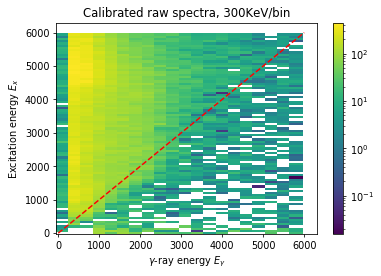

In [12]:
#plot raw matrix
raw_plot_calib = raw.copy()
raw_plot_calib.cut('Ex', 0, 6000)
raw_plot_calib.cut('Eg', 0, 6000)
fig, ax = plt.subplots();
raw_plot_calib.plot(ax=ax, title='Calibrated raw spectra, 300KeV/bin');
x = np.linspace(0, 6000, 100)
ax.plot(x, x, "r--", label="E_x = E_g");
#ax.plot(x, np.ones(100)*B_f_outer*1000, 'r--')
fig.savefig('plots/raw_calibrated_w_diag_300', dpi=1000)


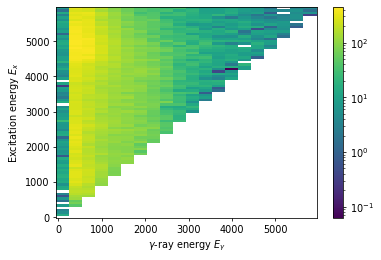

In [13]:
# Cut away counts above the diagonal
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.

raw.cut_diagonal(E1=(200, 0), E2=(7700, 7500))
raw.cut('Ex', 0, 6000)
raw.cut('Eg', 0, 6000)
raw.plot();

From the GettingStarted OmPy manual: "Eventhough this experiment was performed with CACTUS, we will now give an example as if the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately."

So, I need to include the detector threshold for CACTUS

In [14]:
### GETTING RESPONSE MATRIX


logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrixes are stored
folderpath = "../OCL_response_functions/nai2012_for_opt13"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 90.44 # (30/1330 = 2.25% ) #SJEKK DENNE

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10., return_table=True)

2020-04-02 12:13:14,247 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.
2020-04-02 12:13:14,332 - ompy.response - INFO - Note: Spectra outside of 360.0 and 15000.0 are extrapolation only.


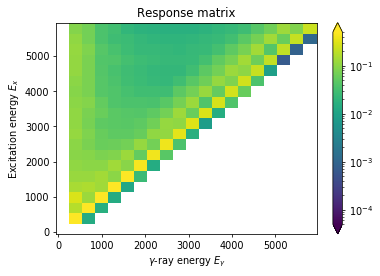

In [15]:
# adding response function for CACTUS
# SJEKK DETTE

fthreshold = sp.interpolate.interp1d([30., 80., 122., 183., 244., 294., 344., 562., 779., 1000.],
                      [0.0, 0.0, 0.0, 0.06, 0.44, 0.60, 0.87, 0.99, 1.00, 1.00],
                      fill_value="extrapolate")

def apply_detector_threshold(response, table, fthreshold):
    thres = fthreshold(response.Eg)
    response.values = response.values * thres
    # renormalize
    response.values = om.div0(response.values, response.values.sum(axis=1)[:, np.newaxis])
    table["eff_tot"] *= thres

apply_detector_threshold(R_ompy_unf, R_tab_unf, fthreshold)
apply_detector_threshold(R_ompy_view, R_tab_view, fthreshold)

R_ompy_view.plot(title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");

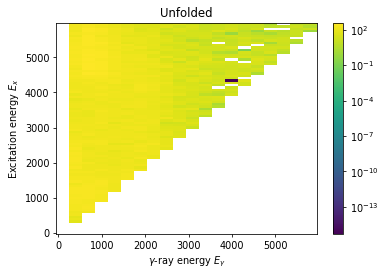

In [16]:
### UNFOLDING

# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=20)


# With compton subtraction and all tweaks
unfolder = om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9} #SJEKK DETTE
unfolded = unfolder(raw_positive)
fig, ax = plt.subplots()
unfolded.plot(ax=ax);
fig.savefig('unfolded')


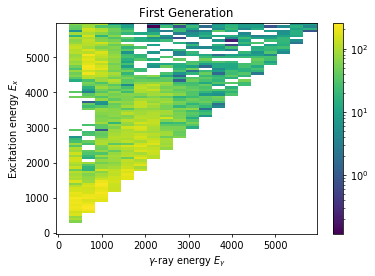

In [17]:
### Generate the first generation matrix

firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

In [18]:
### Propagating statistical uncertainties

logger = om.introspection.get_logger('ensemble', 'INFO')

# Tell the `Ensemble` class which raw spectrum, what kind of undolfer and first
# generations method to use.
# Note: This will have the same setting as above. We could for example have
# set the first generations method to use a different "valley_collection", or a
# differnt type of "multiplicity_estimation"
ensemble = om.Ensemble(raw=raw_positive)
ensemble.unfolder = unfolder
ensemble.first_generation_method = firstgen
# Generates N perturbated members; here just 10 to speed it up
# the `regenerate` flag ensures, that we don't load from disk; which might result in expected results
# if we have changed something in the input `raw` matrix.
ensemble.generate(10, regenerate=True)

2020-04-02 12:13:16,170 - ompy.ensemble - INFO - Start normalization with 3 cpus
2020-04-02 12:13:16,258 - ompy.ensemble - INFO - Generating 0
2020-04-02 12:13:16,289 - ompy.ensemble - INFO - Generating 1
2020-04-02 12:13:16,385 - ompy.ensemble - INFO - Generating 2


2020-04-02 12:13:16,696 - ompy.ensemble - INFO - Generating 3
2020-04-02 12:13:16,862 - ompy.ensemble - INFO - Generating 4
2020-04-02 12:13:16,975 - ompy.ensemble - INFO - Generating 5
2020-04-02 12:13:17,191 - ompy.ensemble - INFO - Generating 6
2020-04-02 12:13:17,424 - ompy.ensemble - INFO - Generating 7
2020-04-02 12:13:17,626 - ompy.ensemble - INFO - Generating 8
2020-04-02 12:13:17,815 - ompy.ensemble - INFO - Generating 9



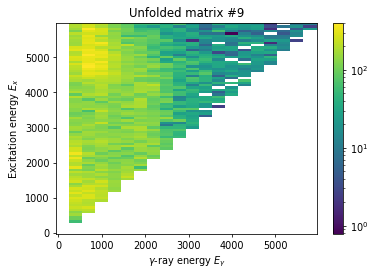

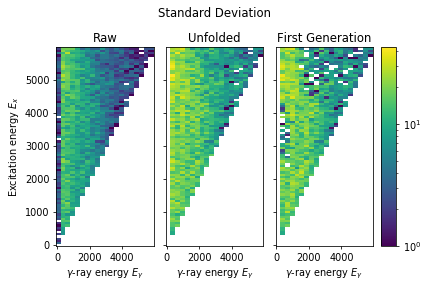

In [19]:
i_unfolded = 9
matrix = ensemble.get_unfolded(i_unfolded)
matrix.plot(title=f"Unfolded matrix #{i_unfolded}")

# Following commands plots all std. deviations
ensemble.plot();

Extract Nuclear level density and gamma strength function

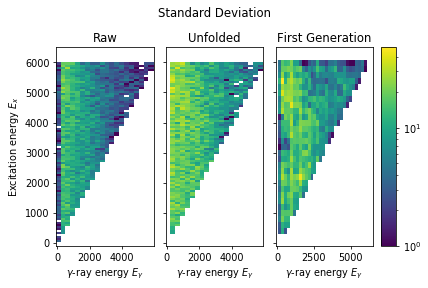

In [20]:
extlog = om.introspection.get_logger('extractor', 'INFO')
trapezoid_cut = om.Action('matrix')
#SJEKK TRAPEZOIDAL CUTS!
trapezoid_cut.trapezoid(Ex_min=1000, Ex_max=6000, Eg_min=1000, Eg_max = 6000+200, inplace=True)
extractor = om.Extractor()
extractor.trapezoid = trapezoid_cut
# Running the lines below directy, would most probably
# result in a error like
# The AssertionError: Ex and Eg must have the same step size
#
# Why? The extraction assumes that Ex and Eg have the same binning. Thus we
# need to rebin the ensemble. This works will work inplace.
# Note: As always, be careful will mid-bin vs lower bin calibration.
#E_rebinned = ensemble.get_firstgen(0).Ex
#
E_rebinned = np.arange(0, 6500, 200.) #RIKTIG BINNING?
ensemble.rebin(E_rebinned, member="firstgen")
ensemble.plot();

In [21]:
extractor.extract_from(ensemble, regenerate=True)

2020-04-02 12:13:21,146 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-02 12:13:21,147 - ompy.extractor - INFO - Minimizing
2020-04-02 12:13:22,194 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04-02 12:13:22,198 - ompy.extractor - INFO -          Current function value: 2283.607523
2020-04-02 12:13:22,201 - ompy.extractor - INFO -          Iterations: 10
2020-04-02 12:13:22,204 - ompy.extractor - INFO -          Function evaluations: 8426
2020-04-02 12:13:22,378 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-02 12:13:22,382 - ompy.extractor - INFO - Minimizing
2020-04-02 12:13:23,378 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04-02 12:13:23,379 - ompy.extractor - INFO -          Current function value: 2423.522379
2020-04-02 12:13:23,380 - ompy.extractor - INFO -          Iterations: 9
2020-04-02 12:13:23,381 - ompy.extractor - INFO -          Function evaluations: 

2020-04-02 12:13:33,404 - ompy.extractor - INFO - Infering calibration that calibration is in keV.
2020-04-02 12:13:33,406 - ompy.extractor - INFO - Minimizing
2020-04-02 12:13:34,500 - ompy.extractor - INFO - Optimization terminated successfully.
2020-04-02 12:13:34,501 - ompy.extractor - INFO -          Current function value: 2283.585769
2020-04-02 12:13:34,502 - ompy.extractor - INFO -          Iterations: 10
2020-04-02 12:13:34,503 - ompy.extractor - INFO -          Function evaluations: 8393


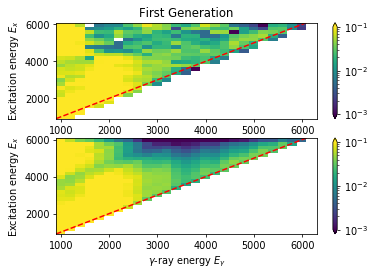

In [22]:
mat = ensemble.get_firstgen(0).copy()
std = ensemble.std_firstgen.copy()
trapezoid_cut.act_on(mat)
trapezoid_cut.act_on(std)
_, _, product = extractor.decompose(mat, std, product=True)

fig, ax = plt.subplots(2,1)
om.normalize_rows(mat.values)
mat.plot(ax=ax[0], scale="log", vmin=1e-3, vmax=1e-1);
product.plot(ax=ax[1], scale="log", vmin=1e-3, vmax=1e-1);

x = np.linspace(*ax[0].get_ylim())
ax[0].plot(x, x, "r--", label="E_x = E_g");
ax[1].plot(x, x, "r--", label="E_x = E_g");

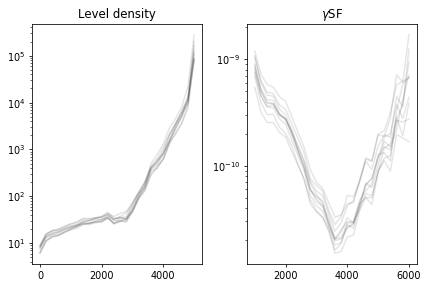

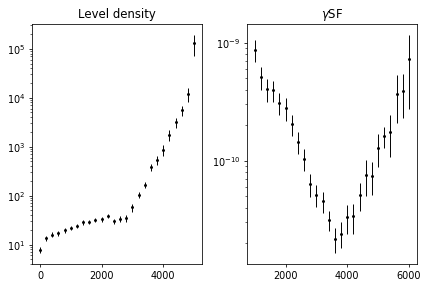

In [23]:
extractor.plot(plot_mean=False);
extractor.plot(plot_mean=True);

In [24]:
# let's remove the nan-valued elements (unconstrained elements) for the further analysis
for nld in extractor.nld:
    nld.cut_nan()

for gsf in extractor.gsf:
    gsf.cut_nan()

# the "mean" nld at this stage; we'll use it later, but it's not a good estimate at this
# stage (see article)
nld_mean = extractor.ensemble_nld()

In [25]:
#Normalization parameters

regenerator = True

norm_pars = om.NormalizationParameters(name='233U')
norm_pars.D0 = [4.6, 0.5]  # eV #SJEKK
norm_pars.Sn = [5.762, 0] # MeV #SJEKK
norm_pars.spincutModel = 'Disc_and_EB05'  # see eg. Guttormsen et al., 2017, PRC 96, 024313
#SJEKK ALLE DISSE
norm_pars.spincutPars = {"mass":233, "NLDa":25.37, "Eshift":-0.51,
                         "Sn": norm_pars.Sn[0], "sigma2_disc":[1.5, 3.6]}
norm_pars.Jtarget = 5/2 # A-1 nucleus

In [26]:
# NLD normalizer parameters

normlog = om.introspection.get_logger('normalizer_nld', 'INFO')
nldnorm = om.NormalizerNLD(nld=extractor.nld[0], discrete='discrete_levels_U233.txt', regenerate=regenerator)
nldnorm.limi_low = [0, 0.5]
nldnorm.limit_high=[1.5, 4.5]
nldnorm.norm_pars = norm_pars

In [27]:
# gSF normalizer parameters

normlog = om.introspection.get_logger('normalizer_gsf', 'INFO')
gsfnorm = om.NormalizerGSF(normalizer_nld=nldnorm, gsf=extractor.gsf[0], regenerate=regenerator)

# to be use for gsf normalization
#SJEKK
norm_pars.Gg = [30.675, 7.4242]  #meV  Found using a mean value of the Gg values from higher and lower isotopes (RIPL3)

gsfnorm.norm_pars = norm_pars
gsfnorm.model_high.Efit = [4.5, 5.5]

In [28]:
nldnorm.normalize(limit_low=[0, 1.5], limit_high=[3, 4.5], norm_pars=norm_pars)

2020-04-02 12:13:38,876 - ompy.normalizer_nld - INFO - 

---------
Normalizing nld #0
2020-04-02 12:13:40,034 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬─────────────────────┬────────────────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]           │ T [MeV]            │ Eshift [MeV]       │
╞═══════════════════╪═════════════════════╪════════════════════╪════════════════════╡
│ 2.306466484234573 │ 0.35038821760871713 │ 0.2883374638102321 │ 1.6759031441854177 │
└───────────────────┴─────────────────────┴────────────────────┴────────────────────┘
2020-04-02 12:13:40,035 - ompy.normalizer_nld - INFO - Starting multinest
  analysing data from multinest/nld_norm_0_.txt
2020-04-02 12:13:56,064 - ompy.normalizer_nld - INFO - Multinest results:
┌─────────────┬───────────────┬───────────────┬──────────────┐
│ A           │ α [MeV⁻¹]     │ T [MeV]       │ Eshift [MeV] │
╞═════════════╪═══════════════╪═══════════════╪══════════════╡
│ 2.44 ± 0.34 │ 0.313 ± 0.083 │ 

In [29]:
gsfnorm.normalize()

2020-04-02 12:13:56,210 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-04-02 12:13:56,467 - ompy.normalizer_gsf - INFO - Saving to normalizers/NormalizerGSF.pkl


Simultaneous normalization of the whole ensemble

In [30]:
normlog = om.introspection.get_logger('normalizer_simultan', 'INFO')
simnorm = om.NormalizerSimultan(normalizer_nld=nldnorm, normalizer_gsf=gsfnorm, regenerate=regenerator)
simnorm.gsf = extractor.gsf[0]
simnorm.nld = extractor.nld[0]

# running faster than the default 400 given less precise answers
# For propper calc. you may rather increase this to > 400.
simnorm.multinest_kwargs["n_live_points"] = 400
simnorm.normalize()

2020-04-02 12:13:57,796 - ompy.normalizer_nld - INFO - DE results:
┌────────────────────┬─────────────────────┬────────────────────┬────────────────────┐
│ A                  │ α [MeV⁻¹]           │ T [MeV]            │ Eshift [MeV]       │
╞════════════════════╪═════════════════════╪════════════════════╪════════════════════╡
│ 2.3064649554277175 │ 0.35038776920620074 │ 0.2883373731123163 │ 1.6759047094504802 │
└────────────────────┴─────────────────────┴────────────────────┴────────────────────┘
2020-04-02 12:13:57,842 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-04-02 12:13:57,847 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌────────────────────┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ A                  │ α [MeV⁻¹]           │ T [MeV]            │ Eshift [MeV]       │ B                  │
╞════════════════════╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 2.30646495542771

In [31]:
normlog = om.introspection.get_logger('normalizer_emsemble_simultan', 'INFO')
ensemblenorm_sim = om.EnsembleNormalizer(extractor=extractor, normalizer_simultan=simnorm, regenerate=regenerator)

ensemblenorm_sim.normalize()

2020-04-02 12:15:40,055 - ompy.normalizer_nld - INFO - DE results:
┌───────────────────┬─────────────────────┬────────────────────┬───────────────────┐
│ A                 │ α [MeV⁻¹]           │ T [MeV]            │ Eshift [MeV]      │
╞═══════════════════╪═════════════════════╪════════════════════╪═══════════════════╡
│ 2.641237544745795 │ 0.45789212361381054 │ 0.2952524989555425 │ 1.571250997778805 │
└───────────────────┴─────────────────────┴────────────────────┴───────────────────┘
2020-04-02 12:15:40,142 - ompy.normalizer_gsf - INFO - Normalizing #0
2020-04-02 12:15:40,152 - ompy.normalizer_simultan - INFO - DE results/initial guess:
┌───────────────────┬─────────────────────┬────────────────────┬───────────────────┬────────────────────┐
│ A                 │ α [MeV⁻¹]           │ T [MeV]            │ Eshift [MeV]      │ B                  │
╞═══════════════════╪═════════════════════╪════════════════════╪═══════════════════╪════════════════════╡
│ 2.641237544745795 │ 0.4578921236

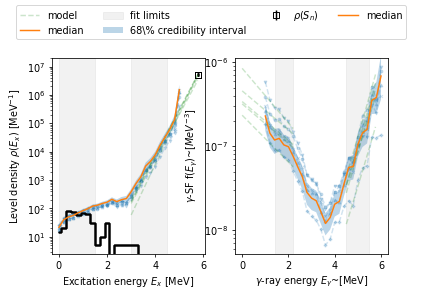

In [32]:
ensemblenorm_sim.plot(n_plot=5, random_state=np.random.default_rng(65546645));

In [33]:
#ensemblenorm_sim.plot(n_plot=5, random_state=np.random.default_rng(65546645));